# K-Means Clustering for Spotify Song Mood Analysis

### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Reading Data

In [3]:
train_df=pd.read_csv("Train.csv")
train_df.head()

,name,uri,genres,artist,mood,length,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,timeSignature
0,feather light melodies,7suV4LZglmw8Kf8JAMHxQU,"['chillhop', 'focus beats', 'lo-fi beats']",santpoort,calm,0 days 00:03:08.893000,0.9490,0.735,0.456,0.878,0.118,-12.937,0.0524,147.970,0.708,4
1,Rained In,19HQQW3lGcT8Yq7svGJnbA,['lo-fi beats'],Nathan Kawanishi,calm,0 days 00:02:37.884000,0.3390,0.491,0.532,0.971,0.257,-9.540,0.0344,65.091,0.102,4
2,Tiger Park,2RKFdXgtbivlmgSGnI7oEz,[],Lo'fi Boy,calm,0 days 00:03:05.696000,0.3210,0.621,0.347,0.944,0.319,-15.032,0.0793,87.918,0.804,4
3,Origami,1Iloy9vXDfjeVSwv3qHpbo,['lo-fi beats'],Deauxnuts,calm,0 days 00:02:09.887000,0.0859,0.773,0.291,0.898,0.117,-15.935,0.0781,80.006,0.601,4
4,Tracy,2wKHx2Bg7AysBPrZ9axL1D,[],Pontiac Puma,calm,0 days 00:02:02.667000,0.7140,0.704,0.245,0.717,0.147,-12.954,0.2160,90.156,0.190,4


### Cleaning data

In [4]:
train_df.columns

Index(['name', 'uri', 'genres', 'artist', 'mood', 'length', 'acousticness',
       'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'timeSignature'],
      dtype='object')

In [5]:
train_df=train_df.drop(columns=['name', 'uri', 'genres', 'artist', 'length'])

In [6]:
train_df.groupby('mood').count()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,timeSignature
mood,,,,,,,,,,
calm,766,766,766,766,766,766,766,766,766,766
energetic,320,320,320,320,320,320,320,320,320,320
happy,346,346,346,346,346,346,346,346,346,346
sad,352,352,352,352,352,352,352,352,352,352


In [8]:
# Filter the DataFrame where mood is 0
filtered_df = train_df[train_df['mood'] == 'calm']

# Randomly select 300 rows from the filtered DataFrame
random_300_rows = filtered_df.sample(n=300)

# Drop the selected rows from the original DataFrame
train_df = train_df.drop(random_300_rows.index)
train_df = train_df.reset_index(drop=True)

In [9]:
train_df['mood'] = train_df['mood'].map({'calm': 0, 'happy': 1, 'sad': 2, 'energetic': 3})
y=train_df['mood']
X=train_df.drop(['mood'], axis=1)
X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,timeSignature
0,0.321,0.621,0.347,0.944,0.319,-15.032,0.0793,87.918,0.804,4
1,0.402,0.694,0.426,0.919,0.178,-8.516,0.0497,136.011,0.366,4
2,0.374,0.636,0.438,0.837,0.873,-12.560,0.0707,149.981,0.915,4
3,0.107,0.748,0.355,0.873,0.239,-12.451,0.0930,87.993,0.195,4
4,0.488,0.766,0.238,0.935,0.124,-11.831,0.0445,105.000,0.394,4


In [10]:
X['timeSignature'].value_counts()

timeSignature
4    1106
3      61
5      10
1       7
Name: count, dtype: int64

In [11]:
X=X.drop(['timeSignature'], axis=1)

In [12]:
X=(X-X.mean())/X.std()
X.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,-0.054890,0.075739,-0.978288,3.011368,1.049457,-1.861811,0.071599,-1.093559,1.352936
1,0.189034,0.606920,-0.658347,2.920320,0.024501,-0.185384,-0.353056,0.654135,-0.383286
2,0.104714,0.184886,-0.609748,2.621685,5.076589,-1.225819,-0.051781,1.161804,1.792937
3,-0.699330,0.999848,-0.945889,2.752793,0.467922,-1.197775,0.268145,-1.090833,-1.061126
4,0.448014,1.130824,-1.419727,2.978591,-0.368035,-1.038263,-0.427657,-0.472801,-0.272295


## PCA for plotting graphs to better analyse K-means

#### Find the eigenvectors and eigenvalues of the covariance matrix 

In [13]:
from numpy.linalg import eig

def eigen_calculation(X):
    cov_mat = np.cov(X.T)
    # Eigendecomposition of covariance matrix
    eig_vals, eig_vecs = eig(cov_mat) 

    # Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
    max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
    signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
    eig_vecs = eig_vecs*signs[np.newaxis,:]
    eig_vecs = eig_vecs.T

    # print('Eigenvalues \n', eig_vals)
    # print('Eigenvectors \n', eig_vecs)
    
    return eig_vals, eig_vecs

In [14]:
def sorted_eigens(X):
    eig_vals,eig_vecs = eigen_calculation(X)
    # We first make a list of (eigenvalue, eigenvector) tuples
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i,:]) for i in range(len(eig_vals))]

    # Then, we sort the tuples from the highest to the lowest based on eigenvalues magnitude
    eig_pairs.sort(key=lambda x: x[0], reverse=True)

    # For further usage
    eig_vals_sorted = np.array([x[0] for x in eig_pairs])
    eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

    # print(eig_pairs)
    
    return eig_vals_sorted, eig_vecs_sorted

In [15]:
def display_explained_var(eig_vals_sorted,eig_vecs):
    eig_vals_total = sum(eig_vals_sorted)
    explained_variance = [(i / eig_vals_total)*100 for i in eig_vals_sorted]
    explained_variance = np.round(explained_variance, 2)
    cum_explained_variance = np.cumsum(explained_variance)

    print('Explained variance: {}'.format(explained_variance))
    print('Cumulative explained variance: {}'.format(cum_explained_variance))

    plt.plot(np.arange(1,len(eig_vals_sorted)+1), cum_explained_variance, '-o')
    plt.xticks(np.arange(1,len(eig_vals_sorted)+1))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance');
    plt.show()

### Principal Component Analysis
#### Also displays the data points belonging to different moods being projected onto the 2 principal components

In [16]:
def PCA(X, n_comp, y):
    X = X.to_numpy()
    X_std = X
    e_val, e_vec = sorted_eigens(X_std)
    # Select top k eigenvectors
    k = n_comp
    W = e_vec[:k, :] # Projection matrix
    # display_explained_var(e_val,e_vec)
    X_proj = X_std.dot(W.T)
    
    # Plotting PCA components
    plt.figure(figsize=(8, 6))
    unique_classes = list(set(y))
    colors = plt.cm.tab10.colors[:len(unique_classes)] # Choose colors from a predefined colormap
    for i, class_label in enumerate(unique_classes):
        class_indices = (y == class_label)
        plt.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1], c=colors[i], label=class_label)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('PCA')
    plt.legend()
    plt.show()


In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def PCA_3D(X, n_comp, y):
    X = X.to_numpy()
    X_std = X
    e_val, e_vec = sorted_eigens(X_std)
    # Select top k eigenvectors
    k = n_comp
    W = e_vec[:k, :] # Projection matrix
    # display_explained_var(e_val,e_vec)
    X_proj = X_std.dot(W.T)
    
    # Plotting PCA components
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    unique_classes = list(set(y))
    colors = plt.cm.tab10.colors[:len(unique_classes)] # Choose colors from a predefined colormap
    for i, class_label in enumerate(unique_classes):
        class_indices = (y == class_label)
        ax.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1], X_proj[class_indices, 2], c=colors[i], label=class_label)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title('PCA in 3D')
    ax.legend()
    plt.show()


## Implementing the model from scratch

In [158]:
import random
class K_Means:
    
    def __init__(self, k=2, tolerance = 0.001, max_iter = 500):
        self.k = k
        self.max_iterations = max_iter
        self.tolerance = tolerance
    
    def euclidean_distance(self, point1, point2):
        #return math.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)   #sqrt((x1-x2)^2 + (y1-y2)^2)
        return np.linalg.norm(point1-point2, axis=0)
        
    def predict(self, data):
        distances = np.array([np.linalg.norm(data - self.centroids[centroid], axis=1) for centroid in self.centroids])
        classification = np.argmin(distances, axis=0)
        return classification
    
    def fit(self, data):
        self.centroids = {}
        # Generate n numbers
        numbers = list(range(0, data.shape[0]))
        
        # Choose k random numbers
        random_numbers = random.sample(numbers, self.k)
        for i in range(self.k):
            self.centroids[i] = data[random_numbers[i]]
        
        
        for i in range(self.max_iterations):
            self.classes = {}
            for j in range(self.k):
                self.classes[j] = []
                
            for point in data:
                distances = []
                for index in self.centroids:
                    distances.append(self.euclidean_distance(point,self.centroids[index]))
                cluster_index = distances.index(min(distances))
                self.classes[cluster_index].append(point)
            
            previous = dict(self.centroids)
            for cluster_index in self.classes:
                self.centroids[cluster_index] = np.average(self.classes[cluster_index], axis = 0)
            

                
            isOptimal = True
            
            for centroid in self.centroids:
                original_centroid = previous[centroid]
                curr = self.centroids[centroid]
                if np.sum((curr - original_centroid)/original_centroid * 100.0) > self.tolerance:
                    isOptimal = False
            if isOptimal:
                break

### Analyzing for different values of k

In [159]:
from sklearn.metrics import silhouette_score
def predict_and_analyse(X, k, y):
    k_means = K_Means(k)
    k_means.fit(X.values)
    
    
    # Plotting starts here
    colors = 10*["r", "g", "c", "b", "k"]
    
    for centroid in k_means.centroids:
        plt.scatter(k_means.centroids[centroid][0], k_means.centroids[centroid][1], s = 130, marker = "x")
    # plt.show()
    for cluster_index in k_means.classes:
        color = colors[cluster_index]
        for features in k_means.classes[cluster_index]:
            plt.scatter(features[0], features[1], color = color,s = 30)
    # plt.show()
    clusters=k_means.predict(X.values)
    print("silhouette score-")
    print(silhouette_score(X, clusters))
    PCA_3D(X,3,clusters)
    df1=pd.DataFrame(clusters)
    df2=pd.concat([df1,y], axis=1)
    for i in range(k):
        print(f"In cluster {i}:")
        print(df2[df2[0] == i].groupby('mood').size())

silhouette score-
0.13074733296250712


C:\Users\hp\AppData\Local\Temp\ipykernel_25440\3328838970.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1], X_proj[class_indices, 2], c=colors[i], label=class_label)


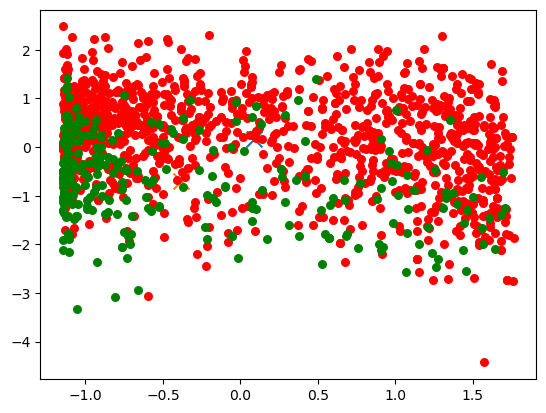

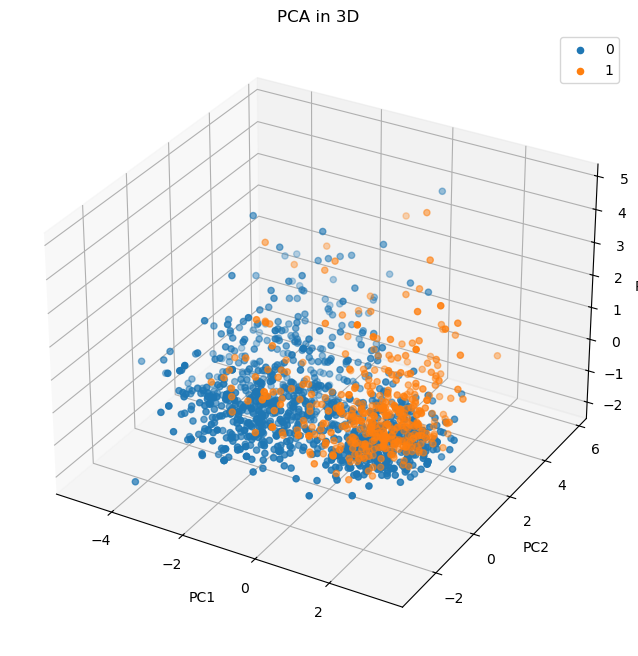

In cluster 0:
mood
0    425
1    196
2    286
3    145
dtype: int64
In cluster 1:
mood
0     41
1    150
2     66
3    175
dtype: int64


In [162]:
predict_and_analyse(X,2,y)

silhouette score-
0.25079674618506365


C:\Users\hp\AppData\Local\Temp\ipykernel_25440\3328838970.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1], X_proj[class_indices, 2], c=colors[i], label=class_label)


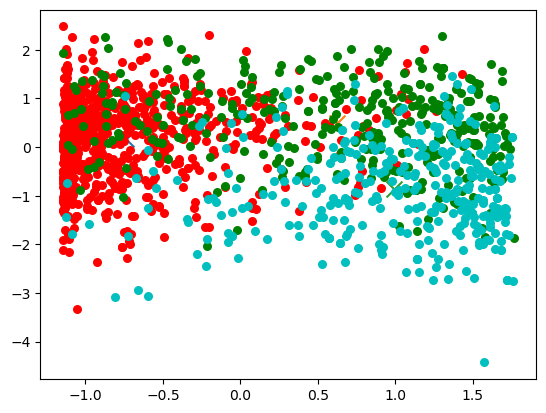

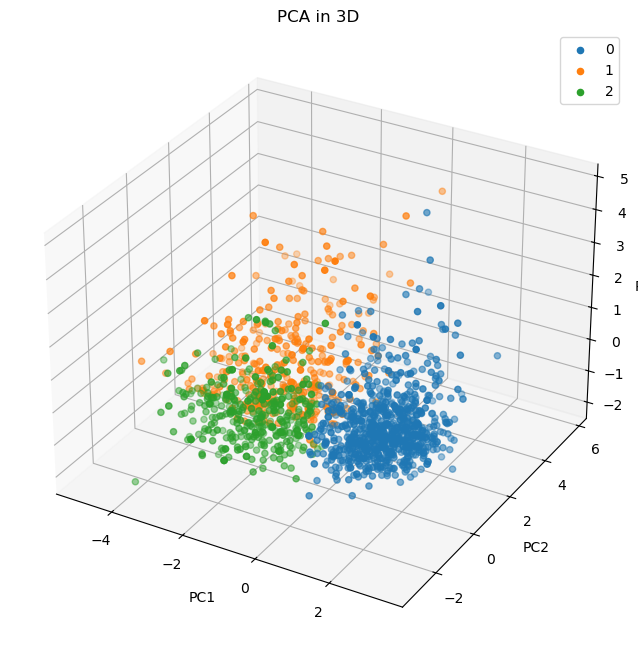

In cluster 0:
mood
0     51
1    332
2     85
3    307
dtype: int64
In cluster 1:
mood
0    326
1      6
2     17
3      6
dtype: int64
In cluster 2:
mood
0     89
1      8
2    250
3      7
dtype: int64


In [168]:
predict_and_analyse(X,3,y)

silhouette score-
0.22361885647575502


C:\Users\hp\AppData\Local\Temp\ipykernel_25440\3328838970.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1], X_proj[class_indices, 2], c=colors[i], label=class_label)


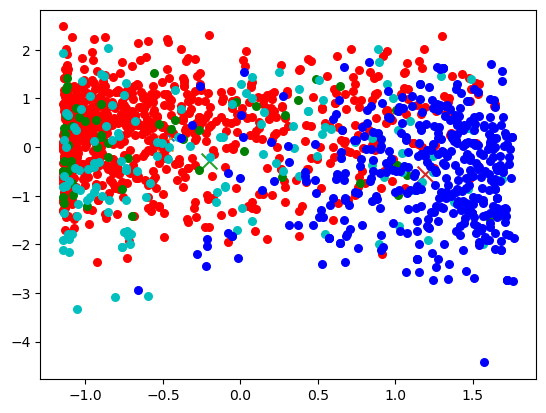

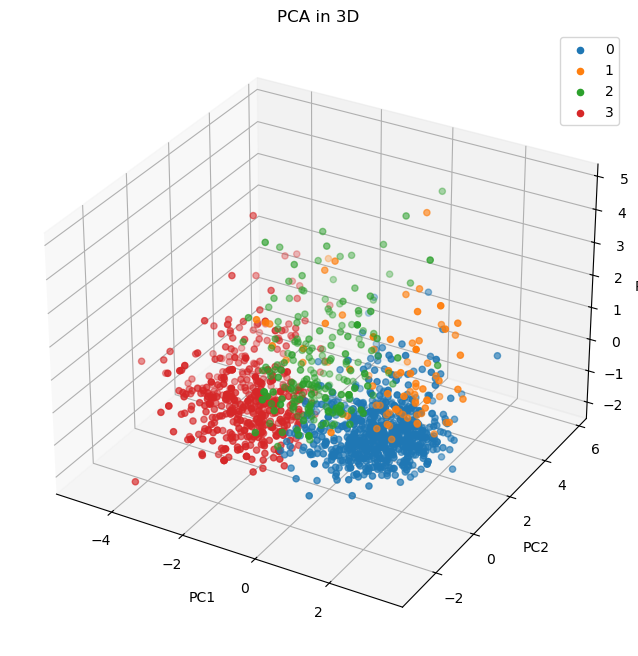

In cluster 0:
mood
0     69
1    301
2     92
3    265
dtype: int64
In cluster 1:
mood
0    10
1    28
2    14
3    29
dtype: int64
In cluster 2:
mood
0    147
1      9
2     27
3     19
dtype: int64
In cluster 3:
mood
0    240
1      8
2    219
3      7
dtype: int64


In [164]:
predict_and_analyse(X,4,y)

silhouette score-
0.1779803088313117


C:\Users\hp\AppData\Local\Temp\ipykernel_25440\3328838970.py:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X_proj[class_indices, 0], X_proj[class_indices, 1], X_proj[class_indices, 2], c=colors[i], label=class_label)


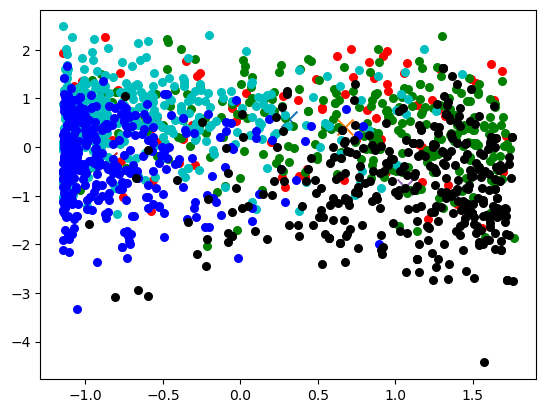

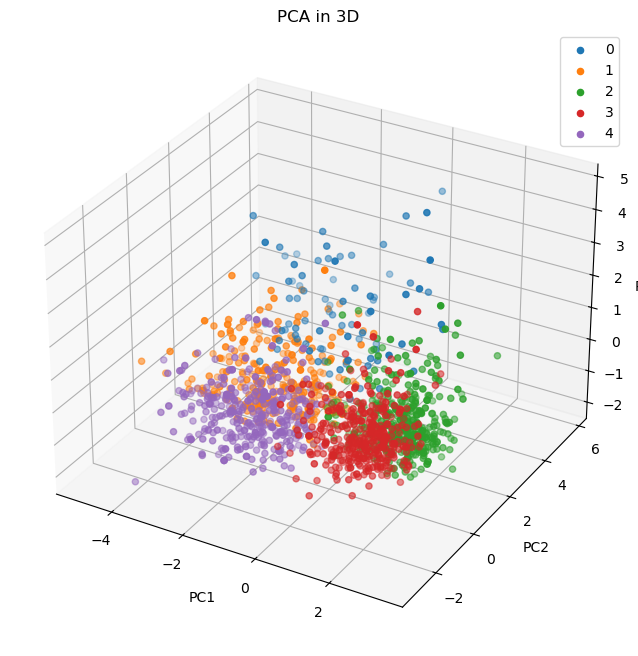

In cluster 0:
mood
0    62
1     4
2     7
3    11
dtype: int64
In cluster 1:
mood
0    256
1      5
2     11
3      5
dtype: int64
In cluster 2:
mood
0     36
1    229
2     31
3     95
dtype: int64
In cluster 3:
mood
0     24
1    100
2     61
3    204
dtype: int64
In cluster 4:
mood
0     88
1      8
2    242
3      5
dtype: int64


In [167]:
predict_and_analyse(X,5,y)

## Comparing with sklearn's implementation

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [21]:
from sklearn.metrics import silhouette_score
def predict_and_analyse_sklearn(X, k, y):
    k_means = KMeans(k)
    k_means.fit(X.values)

    pca=PCA(n_components=3)
    df= pca.fit_transform(X)
    clusters=k_means.predict(X.values)

    
    print("silhouette score-")
    print(silhouette_score(X, clusters))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df[:,0],df[:,1], df[:,2], c=clusters, cmap='rainbow')
    
    df1=pd.DataFrame(clusters)
    df2=pd.concat([df1,y], axis=1)
    for i in range(k):
        print(f"In cluster {i}:")
        print(df2[df2[0] == i].groupby('mood').size())

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


silhouette score-
0.2868164481817126
In cluster 0:
mood
0    138
1     16
2    269
3     11
dtype: int64
In cluster 1:
mood
0     28
1    330
2     83
3    309
dtype: int64


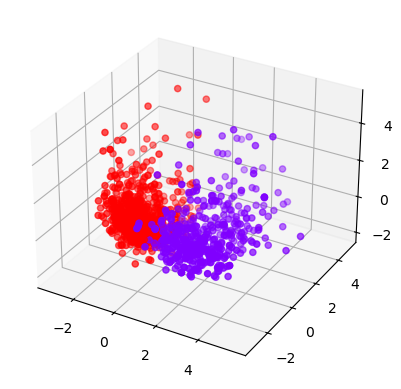

In [23]:
predict_and_analyse_sklearn(X, 2, y)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


silhouette score-
0.2859438947762369
In cluster 0:
mood
0     34
1      9
2    254
3      7
dtype: int64
In cluster 1:
mood
0     19
1    332
2     83
3    305
dtype: int64
In cluster 2:
mood
0    113
1      5
2     15
3      8
dtype: int64


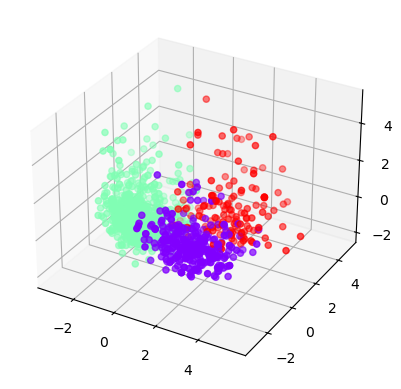

In [24]:
predict_and_analyse_sklearn(X, 3, y)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


silhouette score-
0.26958349585903973
In cluster 0:
mood
0     7
1    34
2    16
3    38
dtype: int64
In cluster 1:
mood
0     16
1    298
2     76
3    267
dtype: int64
In cluster 2:
mood
0    110
1      5
2     13
3      8
dtype: int64
In cluster 3:
mood
0     33
1      9
2    247
3      7
dtype: int64


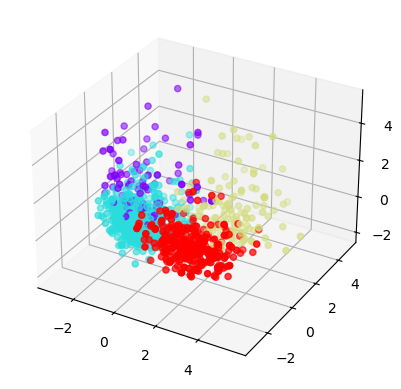

In [25]:
predict_and_analyse_sklearn(X, 4, y)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


silhouette score-
0.18686392439136687
In cluster 0:
mood
0     10
1    195
2     29
3     75
dtype: int64
In cluster 1:
mood
0    110
1      5
2     13
3      7
dtype: int64
In cluster 2:
mood
0     32
1      9
2    239
3      5
dtype: int64
In cluster 3:
mood
0     6
1    53
2    15
3    53
dtype: int64
In cluster 4:
mood
0      8
1     84
2     56
3    180
dtype: int64


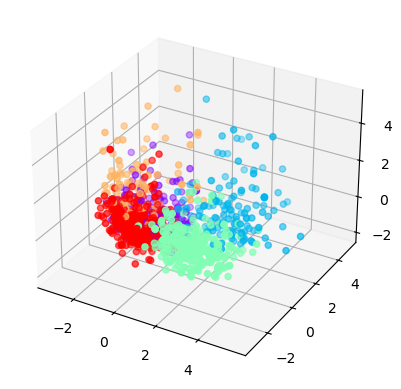

In [26]:
predict_and_analyse_sklearn(X, 5, y)